In [1]:
import sys
import os

# Ruta relativa desde el notebook a la carpeta de scripts
sys.path.append(os.path.abspath("../scripts"))

In [2]:
import numpy as np
import pandas as pd
import torch as t
from datasets import Dataset
from dataset_utils import df_to_dataset
import task1_config as config

c:\Users\sdami\OneDrive\Escritorio\Misongyny\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TASK = "task1"

### Training Dataset

In [13]:
train_df = pd.read_csv(f"../datasets/sub{TASK}_train_rev002.csv", encoding="utf-8")
test_df  = pd.read_csv(f"../datasets/{TASK}_public_test_rev002.csv", encoding="utf-8")

print(f"train: {train_df.columns}")
print(f"test: {test_df.columns}")

train: Index(['id', 'lyrics', 'label'], dtype='object')
test: Index(['id', 'lyrics'], dtype='object')


In [14]:
train_df['label'].unique()

array(['NM', 'M'], dtype=object)

In [15]:
train_df['label'] = train_df['label'].apply(lambda x: 0 if x == "NM" else 1)

In [16]:
train_dataset, con_dict = df_to_dataset(train_df, columns=train_df.columns)
test_dataset, _ = df_to_dataset(test_df, columns=test_df.columns, contractions_dict=con_dict)

In [17]:
# train
def get_values(songs):
    quantile      = 0.95
    values = {}

    values["song_sizes"]    = [ len(song) for song in songs ]
    values["song_mean"]     = np.mean(values["song_sizes"])
    values["song_quartile"] = np.quantile(values["song_sizes"], q=quantile)

    values["sent_sizes"]    = [len(sentence.split(" ")) for song in songs for sentence in song]
    values["sent_mean"]     = np.mean(values["sent_sizes"])
    values["sent_quartile"] = np.quantile(values["sent_sizes"], q=quantile)

    return values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_statistics(traindataset, testdataset):
    train_values = get_values(traindataset["songs"])
    test_values  = get_values(testdataset["songs"])

    fig, axs = plt.subplots(2, 2)

    mean_params = {"color":"red", "linestyle":"dashed", "linewidth":2}
    quantile_params = {"color":"green", "linestyle":"dashed", "linewidth":2}

    axs[0,0].hist(train_values["song_sizes"], bins=np.arange(1, len(train_values["song_sizes"]), 10))
    axs[0,0].axvline(train_values["song_mean"], label=f"Train_Mean = {train_values["song_mean"]:.2f}", **mean_params)
    axs[0,0].axvline(train_values["song_quartile"], label=f"Train_q = {train_values["song_quartile"]:.2f}", **quantile_params)
    axs[0,0].set_title("Number of sentences per song train")

    axs[0,1].hist(test_values["song_sizes"], bins=np.arange(1, len(test_values["song_sizes"]), 10))
    axs[0,1].axvline(test_values["song_mean"], label=f"Test_Mean = {test_values["song_mean"]:.2f}", **mean_params)
    axs[0,1].axvline(test_values["song_quartile"], label=f"Test_q = {test_values["song_quartile"]:.2f}", **quantile_params)
    axs[0,1].set_title("Number of sentences per song test")

    axs[1,0].hist(train_values["sent_sizes"], bins=np.arange(1, len(train_values["sent_sizes"]), 10))
    axs[1,0].axvline(train_values["sent_mean"], label=f"Train_Mean = {train_values["sent_mean"]:.2f}", **mean_params)
    axs[1,0].axvline(train_values["sent_quartile"], label=f"Train_q = {train_values["sent_quartile"]:.2f}", **quantile_params)
    axs[1,0].set_title("Number of words per sentence train")

    axs[1,1].hist(test_values["sent_sizes"], bins=np.arange(1, len(test_values["sent_sizes"]), 10))
    axs[1,1].axvline(test_values["sent_mean"], label=f"Test_Mean = {test_values["sent_mean"]:.2f}", **mean_params)
    axs[1,1].axvline(test_values["sent_quartile"], label=f"Test_q = {test_values["sent_quartile"]:.2f}", **quantile_params)
    axs[1,1].set_title("Number of words per sentence test")

    fig.legend()

plt.show()

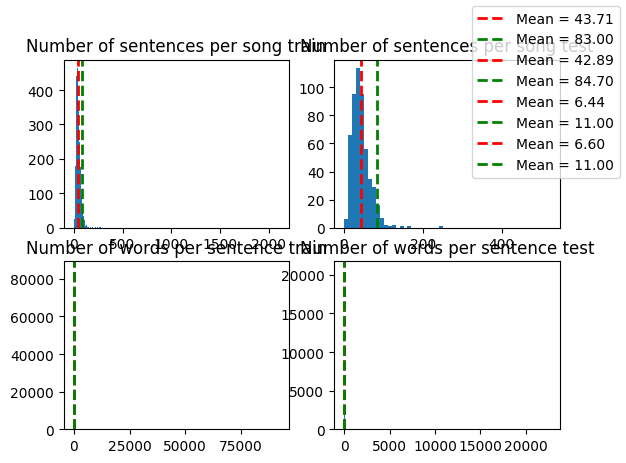

In [21]:
plot_statistics(train_dataset, test_dataset)

max value: 68
quantile 0.95: 105 / 2104 


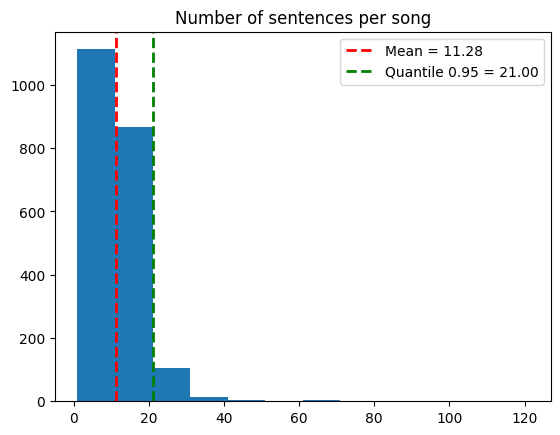

In [50]:
plot_song_hist(train_dataset_v5['songs'], 0.95)

max value: 212
quantile 0.95: 1568 / 31357 


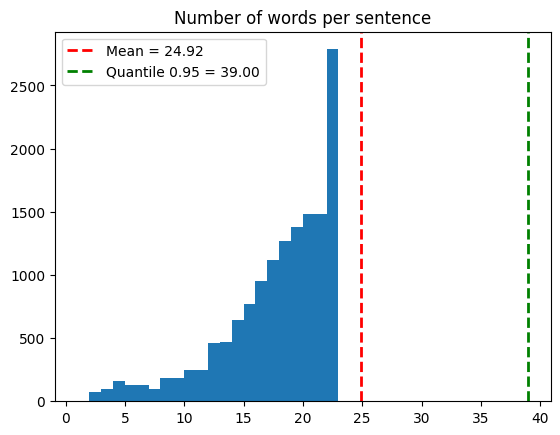

In [53]:
plot_sentence_length(train_dataset_v6['songs'])

In [ ]:
idx = 1605

def compare_texts_side_by_side(text1, text2, width=80):
    lines1 = text1.splitlines()
    lines2 = text2.splitlines()
    max_lines = max(len(lines1), len(lines2))
    lines1 += [''] * (max_lines - len(lines1))
    lines2 += [''] * (max_lines - len(lines2))

    for l1, l2 in zip(lines1, lines2):
        print(f"{l1:<{width}} | {l2}")


compare_texts_side_by_side(train_df["lyrics"].iloc[idx], "\n".join(train_dataset['songs'][idx]))

| Version | Descripcion |
|-|-|
| v1 | cada oración de la canción individual |
| v2 | eliminar oraciones en inglés |
| v3 | eliminar oraciones repetidas (unique) |
| v4 | eliminar oraciones repetidas consecutivas |
| v5 | grupos de oraciones |
| v6 | grupos de oraciones traslapadas |

In [ ]:
train_dataset.save_to_disk(f'../datasets/{TASK}_mil_v1')

In [16]:
def get_unique_sentences(entry):
    sentences = entry["songs"]
    return {
        "songs": list(dict.fromkeys(sentences))
    }

train_dataset_v3 = train_dataset.map(get_unique_sentences, batched=False)
train_dataset_v3.save_to_disk(f'../datasets/{TASK}_mil_v3')

Saving the dataset (1/1 shards): 100%|██████████| 2104/2104 [00:00<00:00, 185336.88 examples/s]


In [17]:
def get_not_repeated_sentences(entry):
    sentences = entry["songs"]
    new_sentences = [sentences[0]]
    for s in sentences:
        if s != new_sentences[-1]:
            new_sentences.append(s)
    
    return {
        "songs": new_sentences 
    }

train_dataset_v4 = train_dataset.map(get_not_repeated_sentences, batched=False)
train_dataset_v4.save_to_disk(f'../datasets/{TASK}_mil_v4')

Saving the dataset (1/1 shards): 100%|██████████| 2104/2104 [00:00<00:00, 190943.06 examples/s]


In [ ]:
def song_by_chunks(entry, chunk_size=4, offset=0):
    n_sentences = len(entry["songs"])
    new_sentences = [ " ".join(entry["songs"][idx:idx+chunk_size]) for idx in range(0, n_sentences, chunk_size - offset) ] 

    return{
        "songs": new_sentences
    }

train_dataset_v5 = train_dataset.map(song_by_chunks, batched=False)
train_dataset_v5.save_to_disk(f'../datasets/{TASK}_mil_v5')

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 2104/2104 [00:00<00:00, 280250.74 examples/s]


In [47]:
kwargs = { "offset": 1}
train_dataset_v6 = train_dataset.map(song_by_chunks, batched=False, fn_kwargs=kwargs)
train_dataset_v6.save_to_disk(f'../datasets/{TASK}_mil_v6')

Saving the dataset (1/1 shards): 100%|██████████| 2104/2104 [00:00<00:00, 227690.17 examples/s]


In [49]:
train_dataset_v6["songs"][10]

['Juro, lo juro, juro, lo juro Juro, lo juro, juro, lo juro Juro, lo juro, juro, lo juro Juro, lo juro, juro, lo juro',
 'Juro, lo juro, juro, lo juro Amarte a ti es como adivinar lo que dirás Otra historia inventarás ¿Qué pudo ser?',
 '¿Qué pudo ser? ¿Por qué habrás cambiado así? No quiero ser quien tenga que dudar de ti Dime por qué',
 'Dime por qué Me dices siempre solamente mentiras Dime por qué No dices nunca la verdad',
 'No dices nunca la verdad Dime por qué Me dices siempre solamente mentiras Dime por qué',
 'Dime por qué No dices nunca la verdad Me enamoré de tu sinceridad Pero sé bien que ya no existe más',
 'Pero sé bien que ya no existe más Hazme sentir que puedo creer en ti Si no es así, ya no podré seguir Dime por qué',
 'Dime por qué Me dices siempre solamente mentiras Dime por qué No dices nunca la verdad',
 'No dices nunca la verdad Dime por qué Me dices siempre solamente mentiras Dime por qué',
 'Dime por qué No dices nunca la verdad Con mis sentimientos Tú estás juga

### Test Set

In [ ]:
test_df = pd.read_csv(f"../datasets/{TASK}_public_test_rev002.csv", encoding="utf-8")
test_df.columns

In [ ]:
test_dataset, _ = df_to_dataset(test_df, columns=test_df.columns, contractions_dict=con_dict)

In [ ]:
plot_song_hist(test_dataset['songs'])

In [ ]:
plot_sentence_length(test_dataset['songs'])

In [ ]:
test_dataset.save_to_disk(f'../datasets/{TASK}_mil_v1_test')

In [ ]:
test_dataset_v5 = test_dataset.map(song_by_chunks, batched=False)
test_dataset_v5.save_to_disk(f'../datasets/{TASK}_mil_v5_test')